# Building a change detection app using Jupyter Dashboard

The Python API, along with the [Jupyter Dashboard](http://jupyter-dashboards-layout.readthedocs.io/) project enables Python developers to quickly build and prototype interactive web apps. This sample illustrates one such app which can be used to detect the changes in vegetation between the two dates. Increases in vegetation are shown in green, and decreases are shown in magenta. 

This sample uses the fast on-the-fly processing power of raster functions available in the `raster` module of the Python API.

<blockquote>To run this sample you need `jupyter_dashboards` package in your conda environment. You can install it as shown below. For information on this, [refer to the install instructions](http://jupyter-dashboards-layout.readthedocs.io/en/latest/getting-started.html#installing-and-enabling)</blockquote>

    conda install jupyter_dashboards -c conda-forge

<img src="../../static/img/02_change_detection_app_01.gif">

### Connect to ArcGIS Online

In [1]:
from arcgis.gis import GIS
from arcgis.geocoding import geocode
from arcgis.raster.functions import *
from arcgis import geometry
    
import pandas as pd

# connect as an anonymous user
gis = GIS()

# search for the landsat multispectral imagery layer
landsat_item = gis.content.search("title:Multispectral Landsat owner:esri", 'Imagery Layer')[0]
landsat = landsat_item.layers[0]
df = None

### Create widget controls to accept place of interest
We use the `widgets` module from `ipywidgets` to create a text box and command button controls. These controls allow the user to specify a place of interest.

In [2]:
import ipywidgets as widgets

# text box widget
location = widgets.Text(value='Ranchi, India', placeholder='Ranchi, India',
                        description='Location:', disabled=False)

# command button widget
gobtn = widgets.Button(description='Go', disabled=False,
                       button_style='', tooltip='Go', icon='check')

# define what happens whent the command button is clicked
def on_gobutton_clicked(b):
    global df
    global m
    global oldslider
    
    # geocode the place name and set that as the map's extent
    area = geocode(location.value)[0]
    m.extent = area['extent']
    df = filter_images()
    
gobtn.on_click(on_gobutton_clicked)

location_items = [location, gobtn]
widgets.HBox(location_items)

Create the map widget and load the landsat imagery layer

In [3]:
m = gis.map(location.value)
m.add_layer(landsat)
display(m)

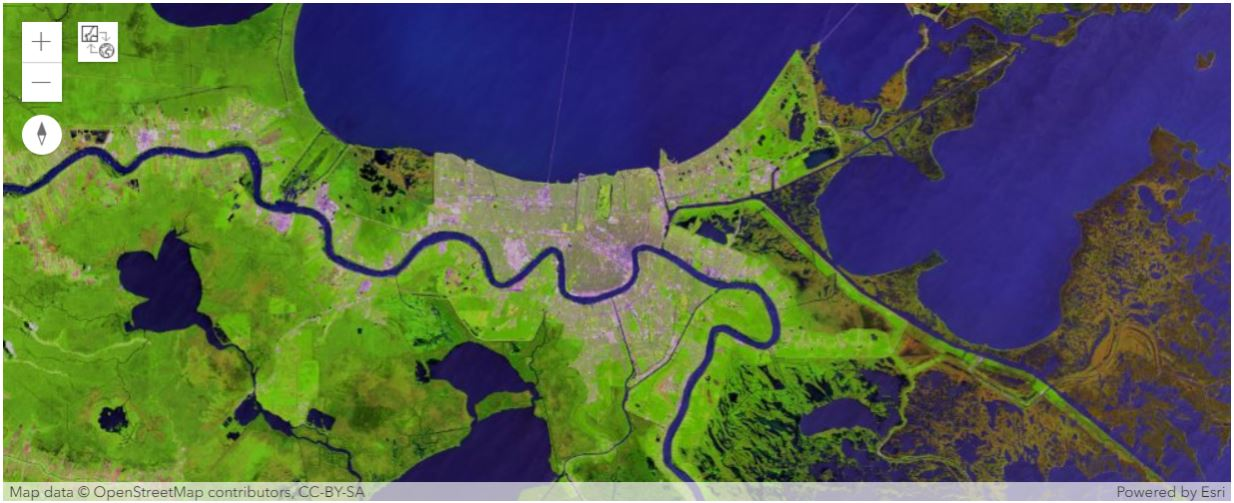

### Create date slider controls
We create two slider controls to pick the before and after dates.

In [4]:
oldindex =  0 # int(len(df)/2)

# before image date slider
oldslider = widgets.IntSlider(value=oldindex, min=0,max=10, #len(df) - 1,
                              step=1, description='Older:', disabled=False,
                              continuous_update=True, orientation='horizontal',
                              readout=False, readout_format='f', slider_color='white')

old_label = widgets.Label(value='')#str(df.Time.iloc[oldindex].date()))

# define the slider behavior
def on_old_value_change(change):
    global df
    i = change['new']
    if df is not None:
        try:
            # print(df.Time.iloc[i].date())
            old_label.value = str(df.Time.iloc[i].date())
        except:
            pass
        
oldslider.observe(on_old_value_change, names='value')    
widgets.HBox([oldslider, old_label])

In [5]:
newindex = 0 # len(df) - 1

# after image date slider
newslider = widgets.IntSlider(value=newindex, min=0, max=10, #len(df) - 1,
                              step=1, description='Newer:', disabled=False,
                              continuous_update=True, orientation='horizontal',
                              readout=False, readout_format='f', slider_color='white')

new_label = widgets.Label(value='') #str(df.Time.iloc[newindex].date()))

# define the slider behavior
def on_new_value_change(change):
    global df
    i = change['new']
    if df is not None:
        try:
        # print(df.Time.iloc[i].date())
            new_label.value = str(df.Time.iloc[i].date())
        except:
            pass
newslider.observe(on_new_value_change, names='value')
widgets.HBox([newslider, new_label])

### Query the time enabled landast imagery layer
Based on the dates selected from the sliders, we filter the layer for images

In [6]:
def update_sliders(tdf):
    global oldslider
    global newslider
    
    oldslider.max = len(tdf) - 1
    newslider.max = len(tdf) -1
    oldindex = int(len(tdf)/2)
    newindex = int(len(tdf) -1)
    oldslider.value = oldindex
    newslider.value = newindex
    old_label.value = str(tdf.Time.iloc[oldindex].date())
    new_label.value = str(tdf.Time.iloc[newindex].date())


def filter_images():
    global df
    area = geocode(location.value, out_sr=landsat.properties.spatialReference)[0]
    extent = area['extent']

    selected = landsat.filter_by(where="(Category = 1) AND (CloudCover <=0.10)", 
                             geometry=geometry.filters.intersects(extent))
    fs = selected.query(out_fields="AcquisitionDate, GroupName, Best, CloudCover, WRS_Row, WRS_Path, Month, Name", 
                  return_geometry=True,
                  return_distinct_values=False,
                  order_by_fields="AcquisitionDate")
    tdf = fs.sdf
    df = tdf
    tdf['Time'] = pd.to_datetime(tdf['AcquisitionDate'], unit='ms')    
    
    if len(tdf) > 1:
        update_sliders(tdf)

    m.draw(tdf.iloc[oldslider.value].SHAPE)
    
    return tdf

In [7]:
df = filter_images()

### Perform change detection when the action button is clicked
We create a command button and when it is clicked, display the difference in NDVI values in shades of green and magenta.

In [8]:
# create the action button
diffbtn = widgets.Button(description='Detect changes', disabled=False,
                         button_style='success', tooltip='Show Different Image',
                         icon='check')

def on_diffbutton_clicked(b):
    # m.clear_graphics()
    first = df.iloc[oldslider.value].OBJECTID
    last = df.iloc[newslider.value].OBJECTID
    old = landsat.filter_by('OBJECTID='+str(first))
    new = landsat.filter_by('OBJECTID='+str(last))
    diff = stretch(composite_band([ndvi(old, '5 4'),
                               ndvi(new, '5 4'),
                               ndvi(old, '5 4')]), 
                               stretch_type='stddev',  num_stddev=3, min=0, max=255, dra=True, astype='u8')
    m.add_layer(diff)
    
diffbtn.on_click(on_diffbutton_clicked)
diffbtn

Button(button_style='success', description='Detect changes', icon='check', style=ButtonStyle(), tooltip='Show …

<blockquote>To run this sample as a dashboard, first run all the cells. Then if you have the `jupyter dashboard` package installed, you should see a `Dashboard View` set of buttons in your cell toolbar. Click on the `Report layout` to specify which cells to hide and then switch to `dashboard preview`.</blockquote>

<img src="../../static/img/02_change_detection_guide_01.gif">

### Conclusion
This sample demonstrates how developers can make use of the Python API and the rich Jupyter ecosystem to quickly build web apps.